In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import os

warnings.filterwarnings('ignore')

SEED = 1234
FIG_SIZE = (10, 7)

In [170]:
train = pd.read_csv('/content/drive/MyDrive/autoML/train.csv')
test = pd.read_csv('/content/drive/MyDrive/autoML/test.csv')

- id
- age : 나이
- workclass : 고용 형태
- fnlwgt : 사람 대표성을 나타내는 가중치 (final weight의 약자)
- education : 교육 수준
- education_num : 교육 수준 수치
- marital_status: 결혼 상태
- occupation : 업종
- relationship : 가족 관계
- race : 인종
- sex : 성별
- capital_gain : 양도 소득
- capital_loss : 양도 손실
- hours_per_week : 주당 근무 시간
- native_country : 국적
- income : 수익 (예측해야 하는 값)

In [171]:
print(train.shape, test.shape)

(26049, 16) (6512, 15)


train, test 의 분포를 따로 봐야하는 이유는 캐글에서 가끔 함정으로 train 에 없는 값 분포를 test에 심어 놓기 때문

In [172]:
train.head()

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0,40,Private,168538,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,>50K
1,1,17,Private,101626,9th,5,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,20,United-States,<=50K
2,2,18,Private,353358,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,16,United-States,<=50K
3,3,21,Private,151158,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,25,United-States,<=50K
4,4,24,Private,122234,Some-college,10,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,20,?,<=50K


In [173]:
test.head()

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,0,28,Private,67661,Some-college,10,Never-married,Adm-clerical,Other-relative,White,Female,0,0,40,United-States
1,1,40,Self-emp-inc,37869,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States
2,2,20,Private,109952,Some-college,10,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,25,United-States
3,3,40,Private,114537,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States
4,4,37,Private,51264,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,99,France


In [174]:
# 결측치
print(train.isnull().sum(),'\n')
print(test.isnull().sum())

id                0
age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64 

id                0
age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
dtype: int64


In [175]:
# 컬럼 별 info() 확인
print(train.info(),'\n')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26049 entries, 0 to 26048
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              26049 non-null  int64 
 1   age             26049 non-null  int64 
 2   workclass       26049 non-null  object
 3   fnlwgt          26049 non-null  int64 
 4   education       26049 non-null  object
 5   education_num   26049 non-null  int64 
 6   marital_status  26049 non-null  object
 7   occupation      26049 non-null  object
 8   relationship    26049 non-null  object
 9   race            26049 non-null  object
 10  sex             26049 non-null  object
 11  capital_gain    26049 non-null  int64 
 12  capital_loss    26049 non-null  int64 
 13  hours_per_week  26049 non-null  int64 
 14  native_country  26049 non-null  object
 15  income          26049 non-null  object
dtypes: int64(7), object(9)
memory usage: 3.2+ MB
None 

<class 'pandas.core.frame.DataFrame'>
Rang

In [176]:
# Target 변환 (Income)
train['income'].value_counts()

<=50K    19744
>50K      6305
Name: income, dtype: int64

In [177]:
# 소득이 50k이하인 사람은 0, 그렇지 않으면 1 (즉, 저소득자 0, 고소득자 1)
train['income'] = train['income'].apply(lambda x: 0 if x == '<=50K' else 1)
train['income'].value_counts()

0    19744
1     6305
Name: income, dtype: int64

# 전처리
train, test 데이터 확인 결과 별다른 이상이 없어서 train+test로 병합하여 전처리한다.

In [178]:
all_data = pd.concat([train, test])
all_data.head(1)

,id,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0,40,Private,168538,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,1.0


## 칼럼별로 살펴보기

### age(나이) 칼럼

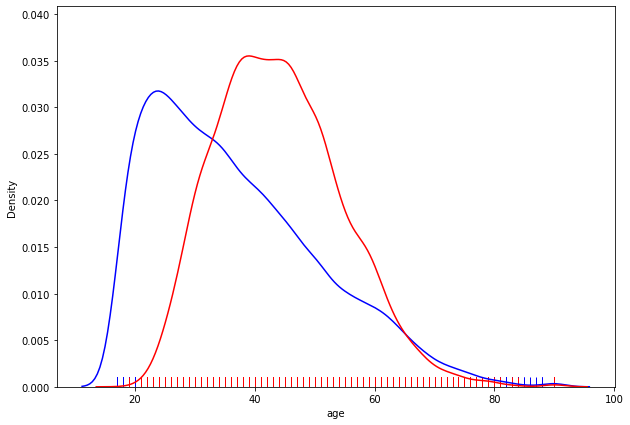

In [179]:
# 소득별 나이 분포
df1 = all_data.loc[all_data['income'] == 0, 'age']
df2 = all_data.loc[all_data['income'] == 1, 'age']

plt.figure(figsize=FIG_SIZE)
sns.distplot(df1, kde=True, rug=True, hist=False, color='blue')
sns.distplot(df2, kde=True, rug=True, hist=False, color='red')

### workclass(고용 형태) 칼럼

In [180]:
all_data['workclass'].value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

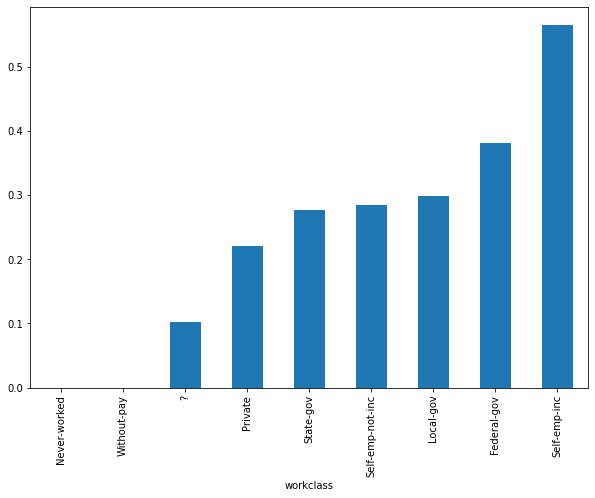

In [181]:
# workclass별 소득평균
all_data.groupby('workclass')['income'].mean().sort_values().plot(kind='bar', figsize=FIG_SIZE)

- Never-worked와 Without-pay의 평균 income이 0이다.

In [182]:
all_data.groupby('workclass')['income'].sum()

workclass
?                    153.0
Federal-gov          292.0
Local-gov            505.0
Never-worked           0.0
Private             3993.0
Self-emp-inc         496.0
Self-emp-not-inc     577.0
State-gov            289.0
Without-pay            0.0
Name: income, dtype: float64

In [183]:
# Never-worked와 Without-pay를 Ohter로 하나로 합친다.
workclass_other = ['Without-pay', 'Never-worked']
all_data['workclass'] = all_data['workclass'].apply(lambda x: 'Other' if x in workclass_other else x)

In [184]:
all_data['workclass'].value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Other                  21
Name: workclass, dtype: int64

### fnlwgt(사람의 대표성을 나타내는 가중치) 칼럼

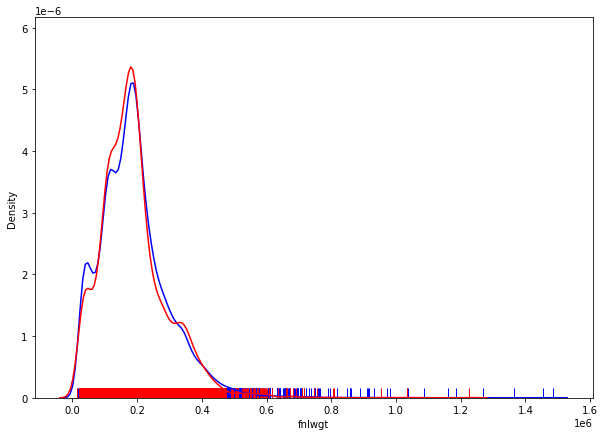

In [185]:
# 소득별 fnlwgt 분포
df1 = all_data.loc[all_data['income'] == 0, 'fnlwgt']
df2 = all_data.loc[all_data['income'] == 1, 'fnlwgt']

plt.figure(figsize=FIG_SIZE)
sns.distplot(df1, kde=True, rug=True, hist=False, color='blue')
sns.distplot(df2, kde=True, rug=True, hist=False, color='red')

- 분포가 거의 차이가 없다.
- 추후 별 특이성이 없다면 피처 제거

In [186]:
# 데이터의 분포가 왜곡되어 있기 때문에 로그를 취해 정규분포로 만든다.
all_data['fnlwgt_log'] = np.log(all_data['fnlwgt'])

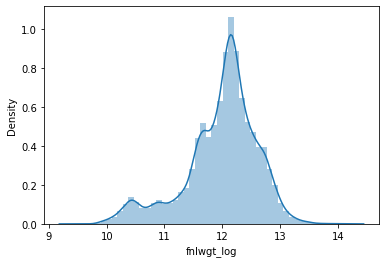

In [187]:
sns.distplot(all_data['fnlwgt_log'])

### education(교육 수준), education_num(교육 수준 수치) 칼럼

In [188]:
print(all_data['education'].value_counts(),'\n')
print(all_data['education_num'].value_counts())

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64 

9     10501
10     7291
13     5355
14     1723
11     1382
7      1175
12     1067
6       933
4       646
15      576
5       514
8       433
16      413
3       333
2       168
1        51
Name: education_num, dtype: int64


In [189]:
# 두 칼럼이 동일하기 때문에 둘 중 하나는 제거
all_data = all_data.drop('education_num', axis=1)

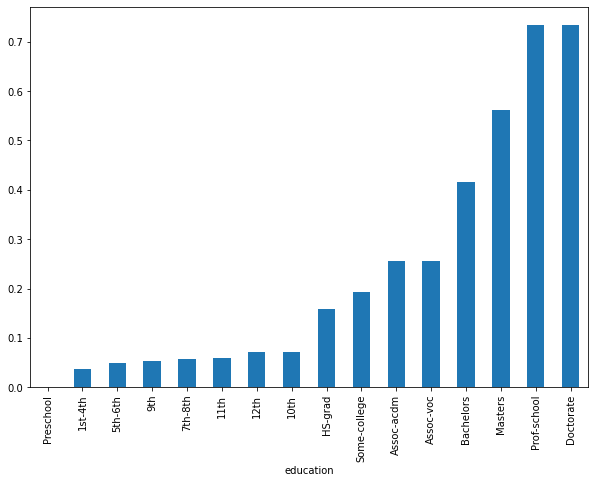

In [190]:
# education별 소득평균
all_data.groupby('education')['income'].mean().sort_values().plot(kind='bar', figsize=FIG_SIZE)

In [191]:
all_data.groupby(['education'])['income'].agg(['mean', 'count']).sort_values('mean')

,mean,count
education,,
Preschool,0.000000,40
1st-4th,0.037313,134
5th-6th,0.049057,265
9th,0.052632,418
7th-8th,0.057426,505
11th,0.059653,922
12th,0.072423,359
10th,0.072503,731
HS-grad,0.158544,8433


In [192]:
# 8단계로 소득 분위 임의 지정
education_map = {
    'Preschool': 'level_0',
    '1st-4th': 'level_1', 
    '5th-6th': 'level_1', 
    '7th-8th': 'level_1', 
    '9th': 'level_2', 
    '10th': 'level_2', 
    '11th': 'level_2', 
    '12th': 'level_2', 
    'HS-grad': 'level_3', 
    'Some-college': 'level_3', 
    'Assoc-acdm': 'level_4', 
    'Assoc-voc': 'level_4', 
    'Bachelors': 'level_5', 
    'Masters': 'level_6', 
    'Prof-school': 'level_7', 
    'Doctorate': 'level_7',
}


In [193]:
all_data['education'] = all_data['education'].map(education_map)

In [194]:
all_data['education'].value_counts()

level_3    17792
level_5     5355
level_2     3055
level_4     2449
level_6     1723
level_1     1147
level_7      989
level_0       51
Name: education, dtype: int64

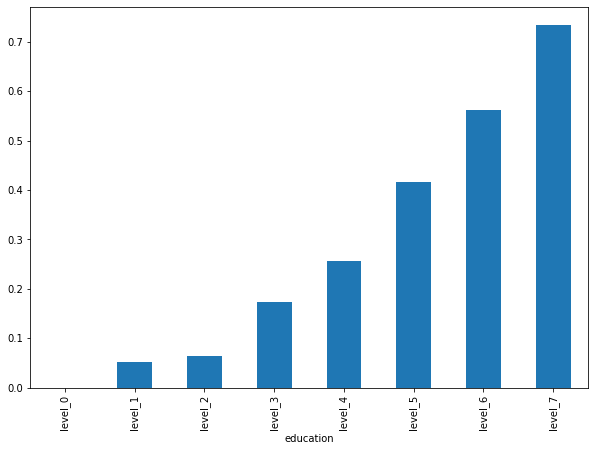

In [195]:
all_data.groupby('education')['income'].mean().sort_values().plot(kind='bar', figsize=FIG_SIZE)

### marital_status(결혼 상태) 칼럼

In [196]:
all_data['marital_status'].value_counts()

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital_status, dtype: int64

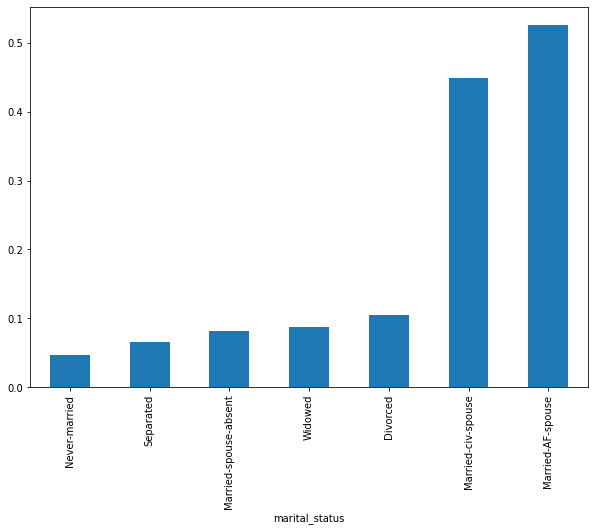

In [197]:
# marital_status별 소득평균
all_data.groupby('marital_status')['income'].mean().sort_values().plot(kind='bar', figsize=FIG_SIZE)

In [198]:
all_data.groupby(['marital_status'])['income'].agg(['mean', 'count']).sort_values('mean')

,mean,count
marital_status,,
Never-married,0.046802,8568
Separated,0.065375,826
Married-spouse-absent,0.080838,334
Widowed,0.087940,796
Divorced,0.104921,3536
Married-civ-spouse,0.448789,11970
Married-AF-spouse,0.526316,19


In [199]:
# 상대적으로 개수가 매우 적은 Married-AF-spouse을 Married-civ-spouse에 포함시킨다.
all_data.loc[all_data['marital_status'] == 'Married-AF-spouse', 'marital_status'] = 'Married-civ-spouse'

### occupation(업종) 칼럼

In [200]:
all_data['occupation'].value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

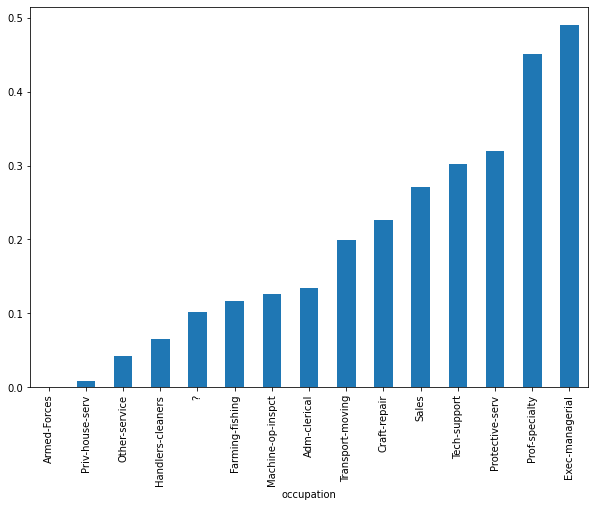

In [201]:
# occupation별 소득평균
all_data.groupby('occupation')['income'].mean().sort_values().plot(kind='bar', figsize=FIG_SIZE)

In [202]:
all_data.groupby('occupation')['income'].sum()

occupation
?                     153.0
Adm-clerical          402.0
Armed-Forces            0.0
Craft-repair          738.0
Exec-managerial      1593.0
Farming-fishing        91.0
Handlers-cleaners      71.0
Machine-op-inspct     200.0
Other-service         110.0
Priv-house-serv         1.0
Prof-specialty       1491.0
Protective-serv       167.0
Sales                 811.0
Tech-support          224.0
Transport-moving      253.0
Name: income, dtype: float64

In [203]:
# Armed-Forces을 Priv-house-serve에 포함시킨다.
all_data.loc[all_data['occupation'].isin(['Armed-Forces', 'Priv-house-serv']), 'occupation'] = 'Priv-house-serv'

In [204]:
all_data['occupation'].value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       158
Name: occupation, dtype: int64

### relationship(가족 관계) 칼럼

In [205]:
all_data['relationship'].value_counts()

Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64

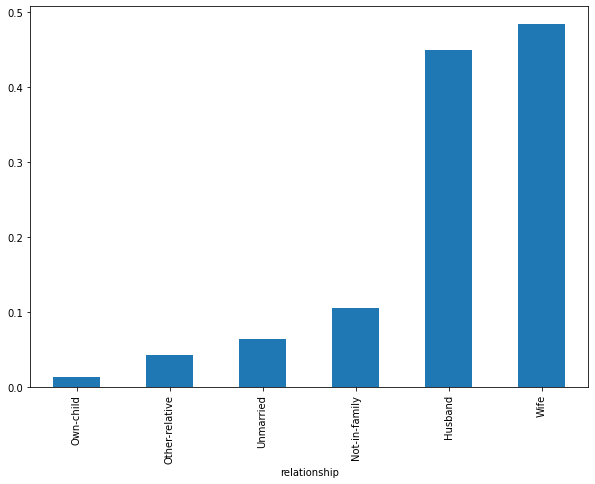

In [206]:
# relationship별 소득평균
all_data.groupby('relationship')['income'].mean().sort_values().plot(kind='bar', figsize=FIG_SIZE)

- 별다른 특이사항이 없어보인다.

### race(인종) 칼럼

In [207]:
all_data['race'].value_counts()

White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64

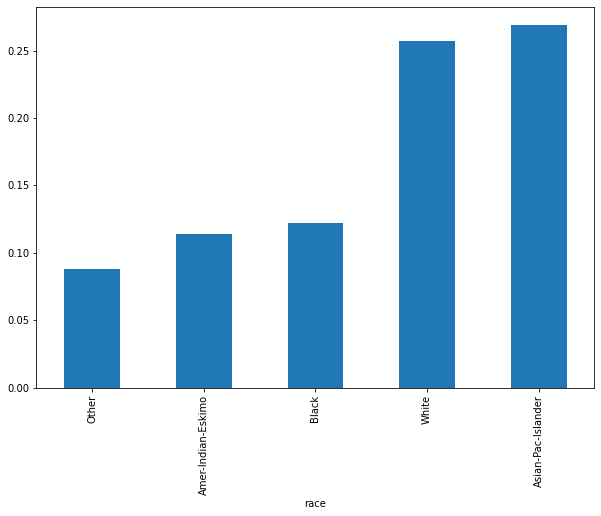

In [208]:
all_data.groupby('race')['income'].mean().sort_values().plot(kind='bar', figsize=FIG_SIZE)

- 별 다른 특이상이 없어보인다.

### sex(성별) 칼럼

In [209]:
all_data['sex'].value_counts()

Male      21790
Female    10771
Name: sex, dtype: int64

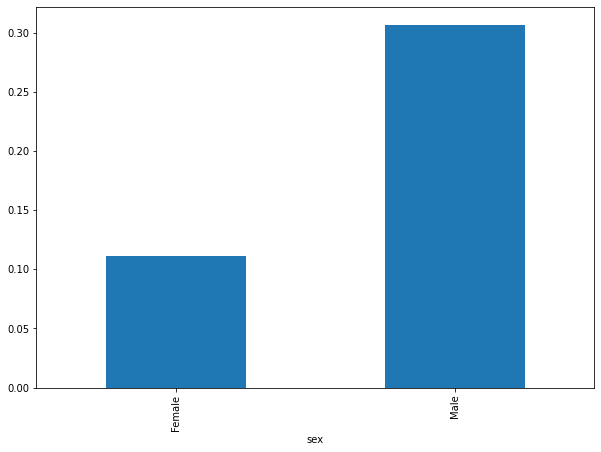

In [210]:
all_data.groupby('sex')['income'].mean().plot(kind='bar', figsize=FIG_SIZE)

- 별다른 특이사항이 없어보인다.

# capital_gain(양도소득), capital_loss(양도 손실) 칼럼

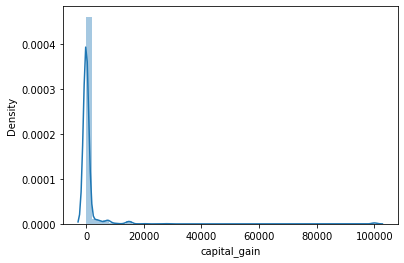

In [211]:
sns.distplot(all_data['capital_gain'])

In [212]:
# 데이터의 분포가 왜곡되어 있기 때문에 로그를 취해 정규분포로 만든다.
all_data['capital_gain_log'] = np.log1p(all_data['capital_gain'])

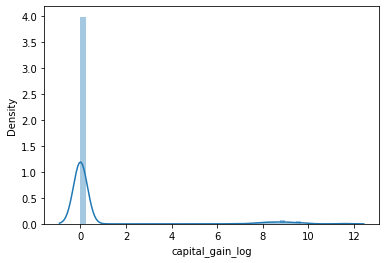

In [213]:
sns.distplot(all_data['capital_gain_log'])

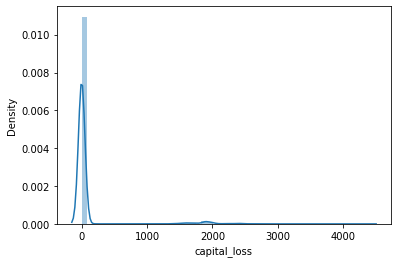

In [214]:
sns.distplot(all_data['capital_loss'])

In [215]:
# 데이터의 분포가 왜곡되어 있기 때문에 로그를 취해 정규분포로 만든다.
all_data['capital_loss_log'] = np.log1p(all_data['capital_loss'])

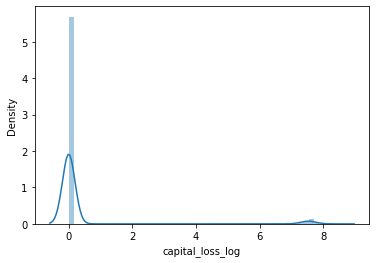

In [216]:
sns.distplot(all_data['capital_loss_log'])

# native_country(국적) 칼럼
- https://en.wikipedia.org/wiki/List_of_countries_by_GNI_(nominal)_per_capita 에 따라 그룹으로 나눈다.
- 사람에 따라 칼럼 자체를 drop한 경우도 있음

In [219]:
all_data['native_country'].value_counts()

United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
Greece                      

In [220]:
income_01 = ['Jamaica',
 'Haiti',
 'Puerto-Rico',
 'Laos',
 'Thailand',
 'Ecuador',]

income_02 = ['Outlying-US(Guam-USVI-etc)',
 'Honduras',
 'Columbia',
 'Dominican-Republic',
 'Mexico',
 'Guatemala',
 'Portugal',
 'Trinadad&Tobago',
 'Nicaragua',
 'Peru',
 'Vietnam',
 'El-Salvador',]

income_03 = ['Poland',
 'Ireland',
 'South',
 'China',]

income_04 = [
    'United-States',
]
income_05 = [
 'Greece',
 'Scotland',
 'Cuba',
 'Hungary',
 'Hong',
 'Holand-Netherlands',
]
income_06 = [
 'Philippines',
 'Canada',
]
income_07 = [
 'England',
 'Germany',
]

income_08 = [
 'Italy',
 'India',
 'Japan',
 'France',
 'Yugoslavia',
 'Cambodia',
]

income_09 = [
 'Taiwan',
 'Iran',
]

income_other=['?', ]

In [221]:
def convert_country(x):
    if x in income_01:
        return 'income_01'
    elif x in income_02:
        return 'income_02'
    elif x in income_03:
        return 'income_03'
    elif x in income_04:
        return 'income_04'
    elif x in income_05:
        return 'income_05'
    elif x in income_06:
        return 'income_06'
    elif x in income_07:
        return 'income_07'
    elif x in income_08:
        return 'income_08'
    elif x in income_09:
        return 'income_09'
    else:
        return 'income_other'

In [222]:
all_data['country_bin'] = all_data['native_country'].apply(convert_country)
all_data['country_bin'].value_counts()

income_04       29170
income_02        1157
income_other      583
income_06         319
income_01         303
income_08         299
income_03         239
income_07         227
income_05         170
income_09          94
Name: country_bin, dtype: int64

## 최종 칼럼 선택

In [223]:
features = [
#     'id', 
    'age', 
    'workclass', 
#     'fnlwgt', 
    'fnlwgt_log', 
    'education', 
    'marital_status',
    'occupation',
    'relationship', 
    'race',
    'sex',
#    'capital_gain',
    'capital_gain_log',
#    'capital_loss', 
    'capital_loss_log', 
    'hours_per_week',
#    'native_country',
    'country_bin'
]

In [224]:
label = [
    'income'
]

In [225]:
# One-Hot Encoding
all_data_dummies = pd.get_dummies(all_data[features + label])

In [232]:
all_data_dummies

,age,fnlwgt_log,capital_gain_log,capital_loss_log,hours_per_week,income,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Other,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,education_level_0,education_level_1,education_level_2,education_level_3,education_level_4,education_level_5,education_level_6,education_level_7,marital_status_Divorced,marital_status_Married-civ-spouse,marital_status_Married-spouse-absent,marital_status_Never-married,marital_status_Separated,marital_status_Widowed,occupation_?,occupation_Adm-clerical,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,country_bin_income_01,country_bin_income_02,country_bin_income_03,country_bin_income_04,country_bin_income_05,country_bin_income_06,country_bin_income_07,country_bin_income_08,country_bin_income_09,country_bin_income_other
0,40,12.034917,0.0,0.0,60,1.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
1,17,11.529055,0.0,0.0,20,0.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
2,18,12.775237,0.0,0.0,16,0.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
3,21,11.926081,0.0,0.0,25,0.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0
4,24,11.713693,0.0,0.0,20,0.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6507,35,11.024236,0.0,0.0,40,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
6508,41,10.379256,0.0,0.0,40,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
6509,39,12.921932,0.0,0.0,40,NaN,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0
6510,35,12.102610,0.0,0.0,40,NaN,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0


In [228]:
train_features = all_data_dummies.drop('income', axis=1).iloc[:len(train)]
test_features = all_data_dummies.drop('income', axis=1).iloc[len(train):]

In [229]:
train_features

,age,fnlwgt_log,capital_gain_log,capital_loss_log,hours_per_week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Other,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,education_level_0,education_level_1,education_level_2,education_level_3,education_level_4,education_level_5,education_level_6,education_level_7,marital_status_Divorced,marital_status_Married-civ-spouse,marital_status_Married-spouse-absent,marital_status_Never-married,marital_status_Separated,marital_status_Widowed,occupation_?,occupation_Adm-clerical,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,country_bin_income_01,country_bin_income_02,country_bin_income_03,country_bin_income_04,country_bin_income_05,country_bin_income_06,country_bin_income_07,country_bin_income_08,country_bin_income_09,country_bin_income_other
0,40,12.034917,0.0,0.0,60,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
1,17,11.529055,0.0,0.0,20,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
2,18,12.775237,0.0,0.0,16,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
3,21,11.926081,0.0,0.0,25,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0
4,24,11.713693,0.0,0.0,20,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26044,57,12.430020,0.0,0.0,52,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
26045,23,12.380412,0.0,0.0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
26046,78,12.017898,0.0,0.0,15,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0
26047,26,11.929172,0.0,0.0,40,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [230]:
test_features

,age,fnlwgt_log,capital_gain_log,capital_loss_log,hours_per_week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Other,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,education_level_0,education_level_1,education_level_2,education_level_3,education_level_4,education_level_5,education_level_6,education_level_7,marital_status_Divorced,marital_status_Married-civ-spouse,marital_status_Married-spouse-absent,marital_status_Never-married,marital_status_Separated,marital_status_Widowed,occupation_?,occupation_Adm-clerical,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,country_bin_income_01,country_bin_income_02,country_bin_income_03,country_bin_income_04,country_bin_income_05,country_bin_income_06,country_bin_income_07,country_bin_income_08,country_bin_income_09,country_bin_income_other
0,28,11.122265,0.0,0.0,40,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0
1,40,10.541888,0.0,0.0,50,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
2,20,11.607799,0.0,0.0,25,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
3,40,11.648653,0.0,0.0,50,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
4,37,10.844744,0.0,0.0,99,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6507,35,11.024236,0.0,0.0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
6508,41,10.379256,0.0,0.0,40,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
6509,39,12.921932,0.0,0.0,40,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0
6510,35,12.102610,0.0,0.0,40,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0
